# Clustering of State Network


**June 12 2020**

In [41]:
from state_lumping_network import StateNetwork
from scipy.stats import wasserstein_distance
from sklearn import cluster
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

##  Lumping functions

Now we are ready to run this clustering code on the entire network. For convenience, StateNetwork provides a method clusterStateNodes that takes an argument clusterFeatureMatrix where you can send in a custom clustering function. This function gets a feature matrix as input argument and expects an array of cluster labels back.

In [42]:
def wasserstein_distances(X):
    return pairwise_distances(X, metric=wasserstein_distance)

def getFeatureClusterFunction(clusterRate=0.50):
    def calcClusters(X):
        numStates, numFeatures = X.shape
        if numStates < 2 or numFeatures < 2: # Mark for playing round with the min num of states 
            # Don't cluster if too small
            return list(range(numStates))

        # Can be an adaptive number of clusters based on entropy reduction
        n_clusters = max(1, int(clusterRate * numStates))
        model = cluster.AgglomerativeClustering(
            linkage="complete",
            #affinity=jensen_shannon_distances,
            affinity = wasserstein_distances,
            #affinity="cosine",
            n_clusters=n_clusters
        )

        labels = model.fit_predict(X)
        return labels
    return calcClusters

## Read in Pathways and Generate State Network



In [43]:

pathNetwork = StateNetwork()
pathNetwork.generateStateNetworkFromPaths("output/CPE_Network_Pathways.net",
                                          "output/CPE_order_m2.net",
                                          outputValidationFilename="output/null.net",
                                          markovOrder=2, splitWeight=True, validationProb=0.0,
                                          minPathLength=1, maxPathLength=40, 
                                          seed=3)

pathNetwork = StateNetwork()
pathNetwork.readFromFile("output/CPE_order_m2.net")

Read path data from file 'output/CPE_Network_Pathways.net'...
Done, parsed 239/526 paths
 -> 0 return paths
Generated training state network: StateNetwork (82 physical nodes, 430 state nodes and 428 links)
Writing state network to file 'output/CPE_order_m2.net'...
Generated validation state network: StateNetwork (0 physical nodes, 0 state nodes and 0 links)
Writing state network to file 'output/null.net'...
Done!
Read state network from file 'output/CPE_order_m2.net'...
 -> StateNetwork (82 physical nodes, 430 state nodes and 428 links)


##  Feature matrix

The feature matrix for a physical node is simply the rows of the state transition matrix for the state nodes belonging to that physical node, and their k-hop neighbors.

The feature matrix and provides a mapping back to the original state network (physical nodes or state nodes)

It takes the physical node id as input parameter and returns a tuple (X, T), where X is the feature matrix (np.array) of size (numNonDanglingStateNodes, numLinkedNodes) and T is a dictionary transforming row index in the feature matrix to state node id.


In [44]:
node = 106

X, rowToStateId = pathNetwork.getFeatureMatrix(node,physicalFeatures=True)
print("Feature matrix for the central physical node: \n{}\n rowToStateId: {}".format(X, rowToStateId))

Feature matrix for the central physical node: 
[[0.36363636 0.18181818 0.45454545 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.57142857 0.28571429 0.14285714
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.24528302 0.09433962 0.32075472 0.         0.         0.
  0.11320755 0.0754717  0.03773585 0.01886792 0.05660377 0.01886792
  0.01886792 0.         0.         0.         0.        ]
 [0.1875     0.04166667 0.22916667 0.         0.         0.
  0.08333333 0.16666667 0.04166667 0.02083333 0.04166667 0.02083333
  0.         0.08333333 0.04166667 0.02083333 0.02083333]
 [0.22727273 0.13636364 0.36363636 0.         0.         0.
  0.18181818 0.         0.         0.         0.04545455 0.
  0.04545455 0.         0.         0.         0.        ]
 [0.15       0.075      0.2        0.  

In [45]:
model = cluster.AgglomerativeClustering(
    linkage="complete",
    affinity = wasserstein_distances,
    #affinity=jensen_shannon_distances,
    #affinity="cosine",
    n_clusters=5
)

labels = model.fit_predict(X)
print("Cluster labels in feature matrix space: {}\nCluster state nodes: {}".format(
    labels,
    {rowToStateId[i]:clusterId for i,clusterId in enumerate(labels)}
))

Cluster labels in feature matrix space: [0 0 1 4 2 1 2 2 3 2]
Cluster state nodes: {3: 0, 48: 0, 73: 1, 89: 4, 126: 2, 132: 1, 136: 2, 274: 2, 324: 3, 336: 2}


##  Lump entire network

Now we are ready to run this clustering code on the entire network. For convenience, StateNetwork provides a method clusterStateNodes that takes an argument clusterFeatureMatrix where we can send our custom clustering function. This function gets a feature matrix as input argument and expects an array of cluster labels back.


In [46]:
pathNetwork.clusterStateNodes(clusterFeatureMatrix=getFeatureClusterFunction(clusterRate=0.5))
#pathNetwork.writeLumpedStateNetwork("output/CPE_order_m2_c25.net")

Cluster state nodes...
Generate lumped state network from clustering...
 -> 221 state nodes and 369 links in lumped network.


## Extract Network from StateNetwork Object

In [47]:
data = []
for sourceId, lumpedStateNode in pathNetwork.lumpedStateNodes.items():
    for targetId, weight in lumpedStateNode.stateLinks.items():
        data.append((sourceId,targetId,weight))
        
state_links = pd.DataFrame(data)
state_links.columns = ['source', 'target','weight']

data = []
for lumpedStateId, lumpedStateNode in pathNetwork.lumpedStateNodes.items():
     data.append((lumpedStateId,lumpedStateNode.physicalId, lumpedStateNode.stateIds))

states = pd.DataFrame(data)
states.columns = ['lumpedStateId', 'physicalId','lumpedStateNode.stateId']

data = []
for physId, physNode in pathNetwork.physNodes.items():
    data.append((physId, physNode.getName()))

phy_nodes = pd.DataFrame(data)
phy_nodes.columns = ['physId', 'name']

In [48]:
# Create Directed graph
D=nx.from_pandas_edgelist(state_links, edge_attr=True,create_using=nx.DiGraph)

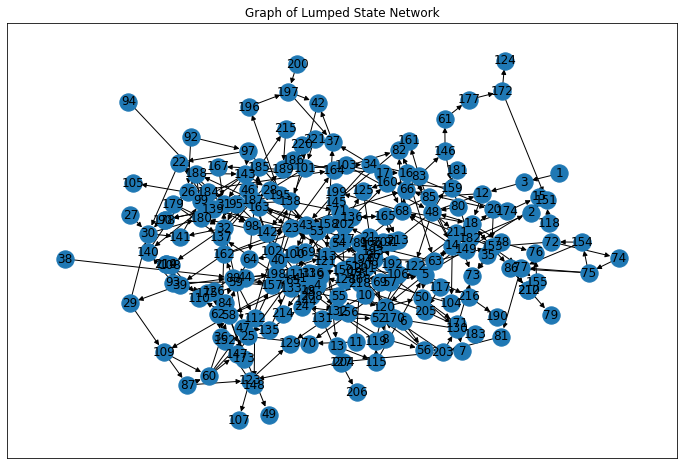

In [55]:
plt.figure(3,figsize=(12,8))
plt.title('Graph of Lumped State Network')
pos=nx.kamada_kawai_layout(D, weight='weight')
nx.draw_networkx(D,pos)
plt.show()

## Weakly Connected Components

Only look at largest weakly conncetec component

In [56]:
[len(c) for c in sorted(nx.weakly_connected_components(D),key=len, reverse=True)]

[204, 5, 2, 2, 2, 2, 2, 2]

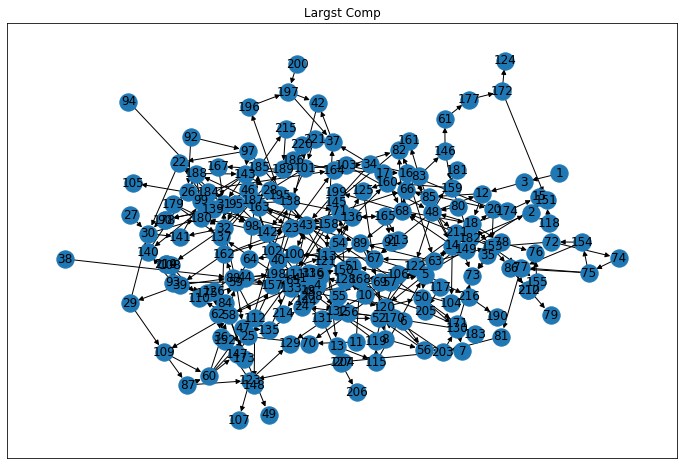

In [57]:
largest = max(nx.weakly_connected_components(D), key=len)
sD = D.subgraph(largest)

plt.figure(3,figsize=(12,8))
plt.title('Largst Comp')
nx.draw_networkx(sD,pos)
plt.show()

In [15]:
edges = nx.to_pandas_edgelist(sD)

In [16]:
edges.to_csv('./output/lumped_network_c25/LargeComp_edges.csv')

In [76]:
adj = nx.adjacency_matrix(sD, weight="weight")

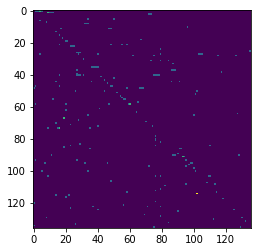

In [77]:
adj = nx.to_scipy_sparse_matrix(sD,weight='weight')


plt.imshow(adj.toarray())

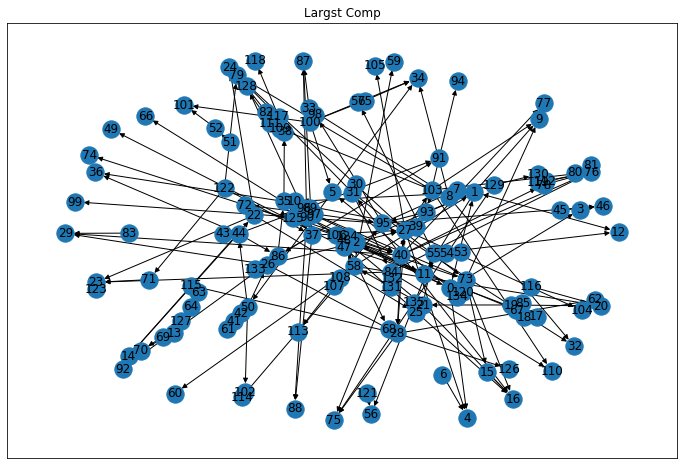

In [80]:
G = nx.from_numpy_matrix(adj.toarray(),create_using=nx.DiGraph)

G.nodes()

plt.figure(3,figsize=(12,8))
plt.title('Largst Comp')
pos=nx.spring_layout(G)
nx.draw_networkx(G,pos)
plt.show()

In [81]:
params = pgs.load_params("params.yaml")
params['min_time'] = -1
params['max_time'] = 1.5

all_results = pgs.run(nx.adjacency_matrix(G, weight="weight") , params)

Warning, your graph is directed!
Warning, you have negative weights, consider using signed constructor.


  0%|          | 0/20 [00:00<?, ?it/s]

Start loop over times...


  0%|          | 0/400 [00:00<?, ?it/s]

Start computing ttprimes...


ValueError: Found input variables with inconsistent numbers of samples: [136, 135]

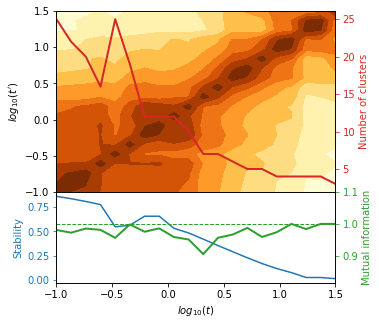

In [60]:
plotting.plot_scan(all_results)

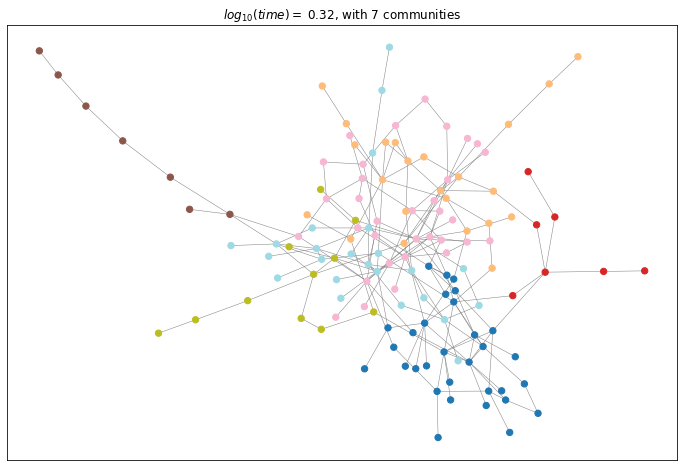

In [59]:
time_id = 10

plt.figure(3,figsize=(12,8))
plt.title('Directed Graph of HOCI Patient Movement')

nx.draw_networkx_nodes(
    G,
    pos=pos,
    #label = list(nx.get_node_attributes(D,'Ward').values()),
    #font_size  = 8,
    node_color=all_results["community_id"][time_id],
    node_size=40,
    cmap=plt.get_cmap("tab20"),
)

nx.draw_networkx_edges(G, pos=pos, width=0.5, edge_color="0.5", font_size  = 8)

plt.title(
        str(r"$log_{10}(time) =$ ")
        + str(np.round(np.log10(all_results["times"][time_id]), 2))
        + ", with "
        + str(all_results["number_of_communities"][time_id])
        + " communities"
    )

plt.show()
